# Imports 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import InputLayer, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

2025-04-16 23:06:23.623918: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744844783.812695      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744844783.868758      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import cv2
from sklearn.utils import resample
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from xgboost import XGBClassifier


# Data Exploration 

In [3]:
data_path = os.path.join('/kaggle/input/covidx-cxr2')
train_data_path = os.path.join(data_path, 'train')
test_data_path = os.path.join(data_path,'test')
train_df = pd.read_csv(os.path.join(data_path, 'train.txt'), sep=" ", index_col=None, header=None)
test_df = pd.read_csv(os.path.join(data_path, 'test.txt'), sep=" ", index_col=None, header=None)

In [4]:
val_data_path = os.path.join(data_path,'val')

val_df = pd.read_csv(os.path.join(data_path, 'val.txt'), sep=" ", index_col=None, header=None)


In [5]:
val_df.head()

,0,1,2,3
0,ANON196,CR.1.2.840.113564.1722810170.20200318082923328...,positive,actmed
1,ANON170,CR.1.2.840.113564.1722810170.20200320011259312...,positive,actmed
2,S03044,sub-S03044_ses-E06138_run-1_bp-chest_vp-ap_cr-...,positive,bimcv
3,S03044,sub-S03044_ses-E07712_run-1_bp-chest_vp-ap_cr-...,positive,bimcv
4,S03044,sub-S03044_ses-E06790_run-1_bp-chest_vp-pa_dx-...,positive,bimcv


In [6]:
train_df.head()

,0,1,2,3
0,379,1e64990d1b40c1758a2aaa9c7f7a85_jumbo.jpeg,negative,cohen
1,379,7223b8ad031187d9a142d7f7ca02c9_jumbo.jpeg,negative,cohen
2,380,3392dc7d262e28423caca517f98c2e_jumbo.jpeg,negative,cohen
3,380,ec3a480c0926ded74429df416cfb05_jumbo.jpeg,negative,cohen
4,382,a72aeb349a63c79ed24e473c434efe_jumbo.jpg,negative,cohen


In [7]:
test_df.head()

,0,1,2,3
0,419639-003251,MIDRC-RICORD-1C-419639-003251-46647-0.png,positive,ricord
1,419639-001464,MIDRC-RICORD-1C-419639-001464-39871-0.png,positive,ricord
2,419639-000918,MIDRC-RICORD-1C-419639-000918-78965-0.png,positive,ricord
3,419639-003318,MIDRC-RICORD-1C-419639-003318-64285-0.png,positive,ricord
4,419639-001015,MIDRC-RICORD-1C-419639-001015-81591-0.png,positive,ricord


In [8]:
train_df.drop(columns = [0,3], axis=1, inplace=True)
test_df.drop(columns = [0,3], axis=1, inplace=True)
val_df.drop(columns = [0,3], axis=1, inplace=True)

In [9]:
test_df.head()

,1,2
0,MIDRC-RICORD-1C-419639-003251-46647-0.png,positive
1,MIDRC-RICORD-1C-419639-001464-39871-0.png,positive
2,MIDRC-RICORD-1C-419639-000918-78965-0.png,positive
3,MIDRC-RICORD-1C-419639-003318-64285-0.png,positive
4,MIDRC-RICORD-1C-419639-001015-81591-0.png,positive


In [10]:
train_df = train_df.rename(columns = {1:'image_name', 2:'diagnosis'})
test_df = test_df.rename(columns = {1:'image_name', 2:'diagnosis'})
val_df=val_df.rename(columns = {1:'image_name', 2:'diagnosis'})

In [11]:
train_df.head()

,image_name,diagnosis
0,1e64990d1b40c1758a2aaa9c7f7a85_jumbo.jpeg,negative
1,7223b8ad031187d9a142d7f7ca02c9_jumbo.jpeg,negative
2,3392dc7d262e28423caca517f98c2e_jumbo.jpeg,negative
3,ec3a480c0926ded74429df416cfb05_jumbo.jpeg,negative
4,a72aeb349a63c79ed24e473c434efe_jumbo.jpg,negative


In [12]:
train_df.diagnosis.value_counts()

diagnosis
positive    57199
negative    10664
Name: count, dtype: int64

In [13]:
test_df.diagnosis.value_counts()

diagnosis
positive    4241
negative    4241
Name: count, dtype: int64

In [14]:
val_df.diagnosis.value_counts()

diagnosis
positive    4241
negative    4232
Name: count, dtype: int64

In [15]:
train_df.isnull().sum()

image_name    0
diagnosis     0
dtype: int64

In [16]:
train_df.duplicated().sum()

0

In [17]:
test_df.isnull().sum()

image_name    0
diagnosis     0
dtype: int64

In [18]:
test_df.duplicated().sum()

0

In [19]:
val_df.isnull().sum()

image_name    0
diagnosis     0
dtype: int64

In [20]:
val_df.duplicated().sum()

0

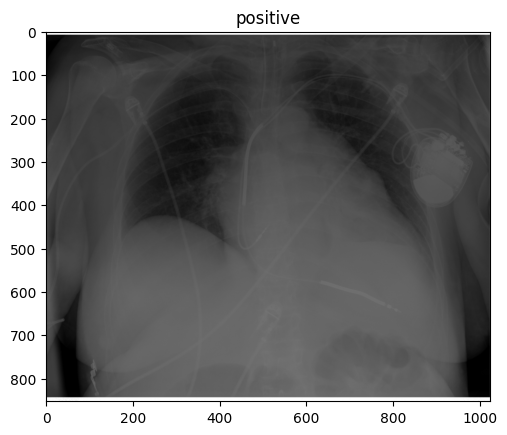

(853, 1024, 3)

In [22]:
rand_indx = np.random.randint(0,len(train_df),1)[0]
img = cv2.imread(os.path.join(train_data_path, train_df.image_name[rand_indx]))
plt.imshow(img/255)
plt.title(train_df.diagnosis[rand_indx])
plt.show()
img.shape

In [23]:
df_majority = train_df[train_df['diagnosis'] == 'positive']
df_minority = train_df[train_df['diagnosis'] == 'negative']

df_minority_upsampled = resample(df_minority, 
                                 replace=True,     
                                 n_samples=len(df_majority), 
                                 random_state=42)

train_df = pd.concat([df_majority, df_minority_upsampled])
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [24]:
train_df.diagnosis.value_counts()

diagnosis
negative    57199
positive    57199
Name: count, dtype: int64

In [25]:
test_df.diagnosis.value_counts()

diagnosis
positive    4241
negative    4241
Name: count, dtype: int64

In [26]:
def custom_preprocess(img):
    img = img.astype(np.uint8)
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    lab = cv2.merge((cl, a, b))
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, mask = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY)
    mask = cv2.medianBlur(mask, 5)
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    img = cv2.bitwise_and(img, mask)

    return img.astype(np.float32) / 255.0

In [27]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_gen = ImageDataGenerator(
    preprocessing_function=custom_preprocess,
    rotation_range=15, zoom_range=0.1, horizontal_flip=True,
    width_shift_range=0.05, height_shift_range=0.05
).flow_from_dataframe(
    dataframe=train_df, directory=train_data_path,
    x_col='image_name', y_col='diagnosis',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='binary', shuffle=True
)

val_gen = ImageDataGenerator(
    preprocessing_function=custom_preprocess
).flow_from_dataframe(
    dataframe=val_df, directory=val_data_path,
    x_col='image_name', y_col='diagnosis',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='binary', shuffle=False
)

Found 114398 validated image filenames belonging to 2 classes.
Found 8473 validated image filenames belonging to 2 classes.


In [28]:
base_model = VGG16(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

I0000 00:00:1744845005.716223      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [29]:
def extract_features_in_batches(generator, model):
    features, labels = [], []
    for i in tqdm(range(len(generator))):
        x_batch, y_batch = generator[i]
        f_batch = model.predict(x_batch, verbose=0)
        features.append(f_batch)
        labels.append(y_batch)
    return np.vstack(features), np.hstack(labels)

In [30]:
features_train, y_train = extract_features_in_batches(train_gen, feature_extractor)
features_val, y_val = extract_features_in_batches(val_gen, feature_extractor)

  0%|          | 0/3575 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1744845009.705600      77 service.cc:148] XLA service 0x7b33ec002b20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744845009.706542      77 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1744845009.840890      77 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1744845017.463247      77 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 265/265 [04:18<00:00,  1.03it/s]


In [31]:
test_datagen = ImageDataGenerator(preprocessing_function=custom_preprocess)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_data_path,
    x_col='image_name',
    y_col='diagnosis',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 8482 validated image filenames belonging to 2 classes.


In [32]:
features_test, y_test = extract_features_in_batches(test_gen, feature_extractor)

100%|██████████| 266/266 [04:13<00:00,  1.05it/s]


In [51]:
print(test_df['diagnosis'].value_counts())

diagnosis
positive    4241
negative    4241
Name: count, dtype: int64


In [56]:
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.5,
    reg_lambda=0.5,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb.fit(features_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [57]:
y_pred_train = xgb.predict(features_train)
print("Train Accuracy:", accuracy_score(y_train, y_pred_train))

Train Accuracy: 0.863118236332803


In [54]:
print("Validation Accuracy:", accuracy_score(y_val, xgb.predict(features_val)))
print("Test Accuracy:", accuracy_score(y_test, xgb.predict(features_test)))


Validation Accuracy: 0.8776112356898383
Test Accuracy: 0.549045036547984


In [55]:
print(np.unique(y_test, return_counts=True))


(array([0., 1.], dtype=float32), array([4241, 4241]))


In [58]:
y_pred_test = xgb.predict(features_test)
y_proba_test = xgb.predict_proba(features_test)[:, 1]

print("\n VGG16 + XGBoost Test Results:")
print(classification_report(y_test, y_pred_test))
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("AUC Score:", roc_auc_score(y_test, y_proba_test))



 VGG16 + XGBoost Test Results:
              precision    recall  f1-score   support

         0.0       0.79      0.14      0.24      4241
         1.0       0.53      0.96      0.68      4241

    accuracy                           0.55      8482
   macro avg       0.66      0.55      0.46      8482
weighted avg       0.66      0.55      0.46      8482

Accuracy: 0.5530535251120019
AUC Score: 0.6505483879451005


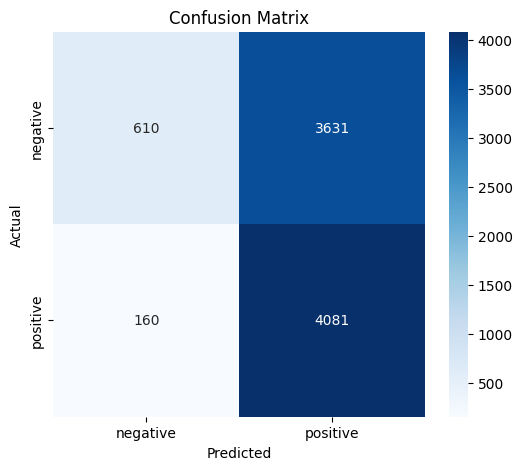

In [39]:
import seaborn as sns


class_labels = ['negative', 'positive']
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [40]:
print("Unique labels in y_train:", np.unique(y_train))
print("Unique labels in y_test:", np.unique(y_test))

Unique labels in y_train: [0. 1.]
Unique labels in y_test: [0. 1.]


In [41]:
print("Test Set Class Distribution:")
print(pd.Series(y_test).value_counts(normalize=True))


Test Set Class Distribution:
1.0    0.5
0.0    0.5
Name: proportion, dtype: float64


In [42]:
print("features_train shape:", features_train.shape)
print("features_val shape:", features_val.shape)
print("features_test shape:", features_test.shape)


features_train shape: (114398, 512)
features_val shape: (8473, 512)
features_test shape: (8482, 512)


In [59]:
y_pred_val = xgb.predict(features_val)
y_proba_val = xgb.predict_proba(features_val)[:, 1]

print("\n VGG16 + XGBoost Validation Results:")
print(classification_report(y_val, y_pred_val))
print("Val Accuracy:", accuracy_score(y_val, y_pred_val))
print("Val AUC Score:", roc_auc_score(y_val, y_proba_val))



 VGG16 + XGBoost Validation Results:
              precision    recall  f1-score   support

         0.0       0.91      0.80      0.85      4232
         1.0       0.82      0.92      0.87      4241

    accuracy                           0.86      8473
   macro avg       0.86      0.86      0.86      8473
weighted avg       0.86      0.86      0.86      8473

Val Accuracy: 0.859553877021126
Val AUC Score: 0.9336383251711954


# Shap

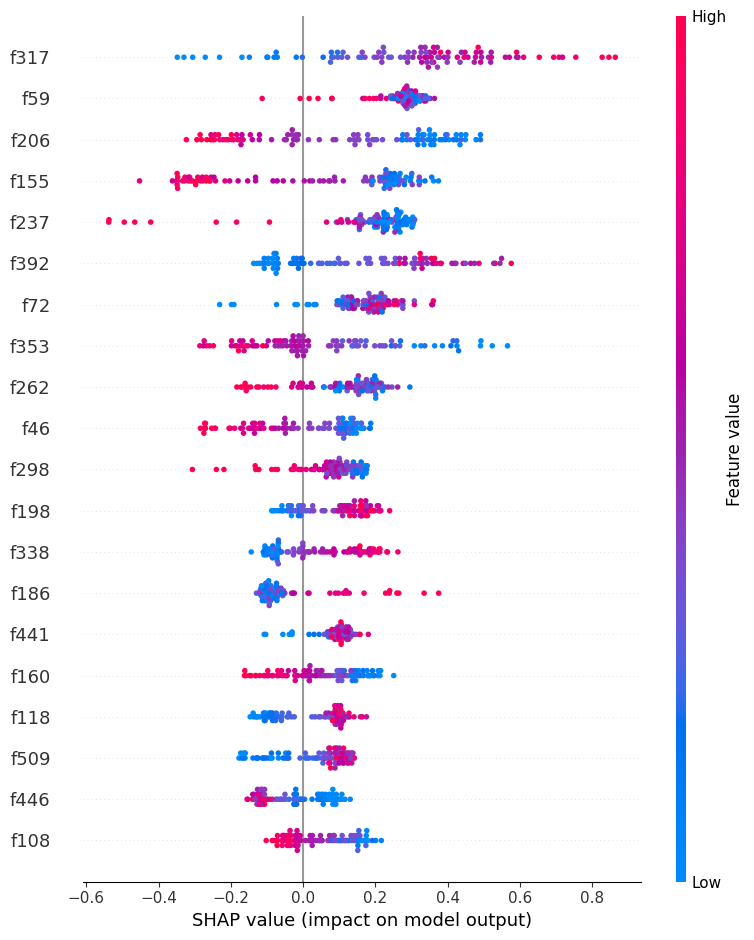

In [61]:
import shap


explainer = shap.Explainer(xgb)
shap_sample = features_test[:100]
shap_values = explainer(shap_sample)

shap.summary_plot(shap_values, shap_sample, feature_names=[f'f{i}' for i in range(shap_sample.shape[1])])

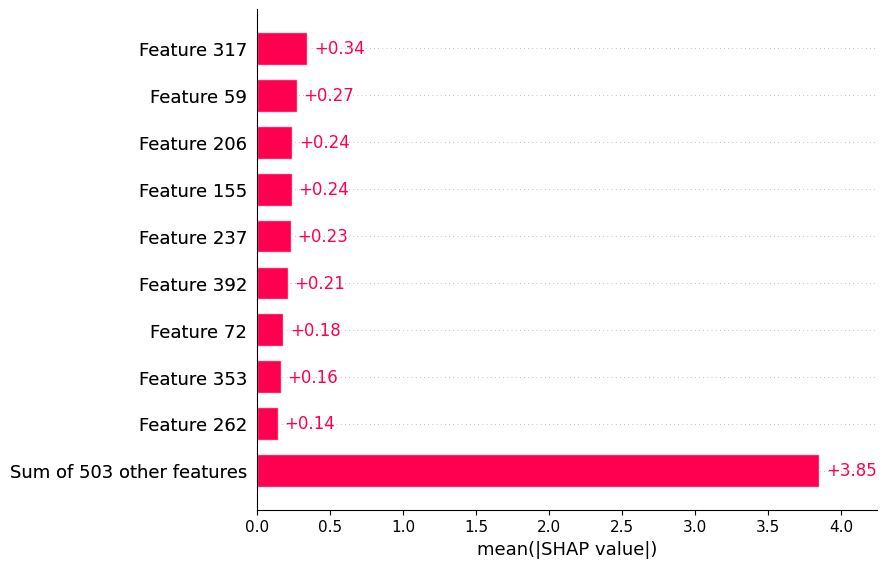

In [62]:
shap.plots.bar(shap_values)

......................